# **Elementary studies on single element**

Test the elementary load cases - tension, compression and sliding

In [582]:
%matplotlib widget
import numpy as np
np.seterr(divide='ignore', invalid='ignore') 
import matplotlib.pylab as plt
from ibvpy.bcond import BCSlice, BCDof
from ibvpy.fets import FETS3D8H
from ibvpy.fets import FETS2D4Q
from ibvpy.tmodel.mats3D import MATS3DElastic
import bmcs_matmod.ms1.concrete_material_db as mp_db
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.xmodel.xdomain_fe_grid import XDomainFEGrid
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym
from ibvpy.api import TStepBC, TFCyclicNonsymmetricConstant, TFBilinear
from mayavi import mlab
from bmcs_matmod.ms1 import MS13D
from ibvpy.tmodel.mats3D.mats3D_microplane.vmats3D_mpl_d_eeq import \
    MATS3DMplDamageEEQ
from ibvpy.bcond import BCSliceI, BCDof
from ibvpy.tfunction import TimeFunction, TFSelector, TFCyclicSin, TFCyclicNonsymmetricConstant
import copy

In [856]:
# CAxisymm = dict(
#     E = 40e+3,
#     nu = 0.18,
#     Ad = 500.0,
#     eps_0 = 0.00001,
#     K_N = 17000.,
#     sigma_N_0 = 45.,
#     gamma_N = 9000.,
#     sigma_T_0 = 0.8,
#     K_T = 1000.0,
#     gamma_T = 1000,
#     S_T = 0.001,
#     c_T = 3.,
#     r_T = 2.,
#     m_T = 0.1,
#     p_T = 1.
# )

# CAxisymm = dict(
#     E = 42e+3,
#     nu = 0.2,
#     Ad = 1800.0,
#     eps_0 = 0.0001,
#     K_N = 17000.,
#     sigma_N_0 = 45.,
#     gamma_N = 9000.,
#     sigma_T_0 = 2.0,
#     K_T = 200.0,
#     gamma_T = 5000,
#     S_T = 0.0075,
#     c_T = 9.,
#     r_T = 5.,
#     m_T = 0.15,
#     p_T = 10.
# )

# CAxisymm = dict(
#     E = 40e+3,
#     nu = 0.18,
#     Ad = 1.0,
#     eps_0 = 0.00001,
#     K_N = 0.,
#     sigma_N_0 = 10.,
#     gamma_N = 0.,
#     sigma_T_0 = 5.0,
#     K_T = 0.0,
#     gamma_T = 0,
#     S_T = 1000.001,
#     c_T = 1.0,
#     r_T = 1.0,
#     m_T = 0.1,
#     p_T = 1.
# )

CAxisymmMDM = dict(
    epsilon_0 = 59.0e-6,
    epsilon_f = 250.0e-6,
    c_T = 0.02,
    E = 42000,
    nu = 0.18
)

CAxisymm = dict(
    E = 40e+3,
    nu = 0.18,
    Ad = 1000.0,
    eps_0 = 0.00001,
    K_N = 0.,
    sigma_N_0 = 1.,
    gamma_N = 0.,
    sigma_T_0 = 0.1,
    K_T = 10.0,
    gamma_T = 10.,
    S_T = 0.00000001,
    c_T = 1.0,
    r_T = 1.0,
    m_T = 0.1,
    p_T = 1.
)

## Complete PTST

In [857]:
n_x_e = 5
n_inner_y_e = 2
n_outer_y_e = 2
L_x = 50.0 # [mm]
d_x = L_x / n_x_e
R_in = 25 # [mm]
dR = 2 # [mm]
R_out = 50 # [mm]
len_notch = 20
n_notch = 1
# geo_transform
# gmesh
xd_inner = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0, 0),
                               coord_max=(L_x, R_in),
                               shape=(n_x_e, n_inner_y_e),
                               fets=FETS2D4Q())
xd_middle = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0+n_notch*d_x, R_in),
                               coord_max=(L_x-n_notch*d_x, R_in+dR),
                               shape=(n_x_e-2*n_notch, 1),
                               fets=FETS2D4Q())
xd_outer = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0, R_in+dR),
                               coord_max=(L_x, R_out),
                               shape=(n_x_e, n_outer_y_e),
                               fets=FETS2D4Q())
m_elastic = MATS3DElastic(E=40000, nu=0.18)
m_inelastic_MDM = MATS3DMplDamageEEQ(**CAxisymmMDM)


m_inelastic = MS13D(**CAxisymm)

m = TStepBC(
    domains=[(xd_inner, m_inelastic_MDM),
             (xd_outer, m_inelastic_MDM),
             (xd_middle, m_inelastic),
             ]
)

## Boundary and transition conditions

In [858]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.1)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=0.1)

### Kinematic links between the domains

In [859]:
link_inner_middle_0 = BCSliceI(var='u', dims=[0],
                             # slice=xd_inner.mesh.I[:, -1], 
                             slice=xd_inner.mesh.I[n_notch:-n_notch, -1], 
                             link_slice=xd_middle.mesh.I[:, 0],
                             link_coeffs=[1],
                             link_dims=[0],
                             value=0,
                            )

link_inner_middle_1 = BCSliceI(var='u', dims=[1],
                             # slice=xd_inner.mesh.I[:, -1], 
                             slice=xd_inner.mesh.I[n_notch:-n_notch, -1], 
                             link_slice=xd_middle.mesh.I[:, 0],
                             link_coeffs=[1],
                             link_dims=[1],
                             value=0,
                            )

link_middle_outer_0 = BCSliceI(var='u', dims=[0],
                             slice=xd_outer.mesh.I[n_notch:-n_notch, 0], 
                             # slice=xd_outer.mesh.I[:, 0], 
                             link_slice=xd_middle.mesh.I[:, -1],
                             link_coeffs=[1],
                             link_dims=[0],
                             value=0,
                            )

link_middle_outer_1 = BCSliceI(var='u', dims=[1],
                             slice=xd_outer.mesh.I[n_notch:-n_notch, 0], 
                             # slice=xd_outer.mesh.I[:, 0], 
                             link_slice=xd_middle.mesh.I[:, -1],
                             link_coeffs=[1],
                             link_dims=[1],
                             value=0,
                            )

# link_middle_outer = BCSliceI(var='u', dims=[0, 1],
#                              slice=xd_middle.mesh.I[n_notch:-n_notch, 0], 
#                              # slice=xd_outer.mesh.I[:, 0], 
#                              link_slice=xd_outer.mesh.I[:, -1],
#                              link_coeffs=[1, 1],
#                              link_dims=[0, 1],
#                              value=0,
#                             )

## Sliding dc + Precompression fc

In [860]:
inner_fixed_1 = BCSliceI(slice=xd_inner.mesh.I[:, 0], var='u', dims=[1], value=0)
outer_fixed_0 = BCSliceI(slice=xd_outer.mesh.I[0, :], var='u', dims=[0], value=0)
outer_fixed_1 = BCSliceI(slice=xd_outer.mesh.I[:, -1], var='u', dims=[1], value=0)

inner_fixed_out_1 = BCSliceI(slice=xd_inner.mesh.I[:, -1], var='u', dims=[1], value=0)

slide = 0.01
inner_slide_slice = BCSliceI(slice=xd_inner.mesh.I[-1, :],
                                   var='u', dims=[0], value=-0.1)

slide_control_dofs = inner_slide_slice.dofs
inner_slide = [BCDof(var='u', dof=dof, value=-slide, time_function=tf_sliding) 
                     for dof in slide_control_dofs ]


outer_compression_slice = BCSliceI(slice=xd_outer.mesh.I[:, -1],
                                   var='u', dims=[1], value=-0.1)

compression_dofs = outer_compression_slice.dofs
compression_stress = -0
compression_force = compression_stress  * 2* np.pi* R_out * L_x / len(compression_dofs)
outer_compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]

compression_dofs_inner = inner_fixed_out_1.dofs
outer_compression_force_inner_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs_inner ]


# outer_compression_force_first = [BCDof(var='u', dof=dof, value=0.01, time_function=tf_precrompression) 
#                                  for dof in compression_dofs ]
# outer_compression_force_first[0].value *=0.5
# outer_compression_force_first[-1].value *=0.5
outer_compression_force_inner_first[0].value *=0.5
outer_compression_force_inner_first[-1].value *=0.5

bc1 =   [inner_fixed_1,
        outer_fixed_0,
        link_middle_outer_0,
         link_middle_outer_1,
        link_inner_middle_0,
         link_inner_middle_1
        ]  + inner_slide + outer_compression_force_first

In [861]:
ligament_upper_slide_slice = BCSliceI(slice=xd_middle.mesh.I[:, -1],
                                   var='u', dims=[0], value=-0.1)
ligament_upper_slide_dofs = ligament_upper_slide_slice.dofs

ligament_lower_slide_slice = BCSliceI(slice=xd_middle.mesh.I[:, 0],
                                   var='u', dims=[0], value=-0.1)
ligament_lower_slide_dofs = ligament_lower_slide_slice.dofs

ligament_upper_confinement_slice = BCSliceI(slice=xd_middle.mesh.I[:, -1],
                                   var='u', dims=[1], value=-0.1)
ligament_upper_confinement_dofs = ligament_upper_confinement_slice.dofs

ligament_lower_confinement_slice = BCSliceI(slice=xd_middle.mesh.I[:, 0],
                                   var='u', dims=[1], value=-0.1)
ligament_lower_confinement_dofs = ligament_lower_confinement_slice.dofs

In [862]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = True
s.tloop.k_max = 1000
s.tline.step = 0.005
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains

In [863]:
s.reset()
s.run()

t:	 0.00(0), 
	 0.01(0), 
	 0.01(0), 
	 0.01(0), 
	 0.02(0), 
	 0.03(0), 
	 0.03(0), 
	 0.04(0), 
	 0.04(0), 
	 0.04(0), 
	 0.05(0), 
	 0.05(0), 
	 0.06(0), 
	 0.06(0), 
	 0.07(0), 
	 0.07(0), 
	 0.08(0), 
	 0.09(0), 
	 0.09(0), 
	 0.10(0), 
	 0.10(0), 
	 0.11(1), 
	 0.11(1), 
	 0.12(1), 
	 0.12(1), 
	 0.13(1), 
	 0.13(7), 
	 0.14(9), 
	 0.14(13), 
	 0.15(14), 
	 0.15(15), 
	 0.16(17), 
	 0.16(20), 
	 0.17(25), 
	 0.17(27), 
	 0.18(28), 
	 0.18(32), 
	 0.19(34), 
	 0.19(35), 
	 0.20(37), 
	 0.20(41), 
	 0.21(40), 
	 0.21(44), 
	 0.22(46), 
	 0.22(46), 
	 0.23(49), 
	 0.23(51), 
	 0.24(56), 
	 0.24(58), 
	 0.25(57), 
	 0.25(63), 
	 0.26(65), 
	 0.26(68), 
	 0.27(74), 
	 0.27(77), 
	 0.28(88), 
	 0.28(91), 
	 0.29(93), 
	 0.29(98), 
	 0.30(108), 
	 0.30(113), 
	 0.31(114), 
	 0.31(115), 
	 0.32(117), 
	 0.32(117), 
	 0.33(150), 
	 0.33(115), 
	 0.34(114), 
	 0.34(117), 
	 0.35(118), 
	 0.35(124), 
	 0.36(125), 
	 0.36(126), 
	 0.37(130), 
	 0.37(131), 
	 0.38(136), 
	 0.38(137), 
	 0.39(

## Postprocesing

### Access the last displacement step

In [864]:
F = m.hist.F_t
U = m.hist.U_t

In [865]:
F_slide = np.sum(F[:, slide_control_dofs], axis=-1)
F_slide_ligament_upper = np.sum(F[:, ligament_upper_slide_dofs], axis=-1)
F_slide_ligament_lower = np.sum(F[:, ligament_lower_slide_dofs], axis=-1)
F_confinement_ligament_upper = np.sum(F[:, ligament_upper_confinement_dofs], axis=-1)
F_confinement_ligament_lower = np.sum(F[:, ligament_lower_confinement_dofs], axis=-1)
U_slide = np.average(U[:, slide_control_dofs], axis=-1)
U_slide_ligament_upper = np.average(U[:, ligament_upper_slide_dofs], axis=-1)
U_slide_ligament_lower = np.average(U[:, ligament_lower_slide_dofs], axis=-1)
U_slide_differential_ligament = U_slide_ligament_upper - U_slide_ligament_lower

Text(0.5, 0, 'Displacement at control[mm]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
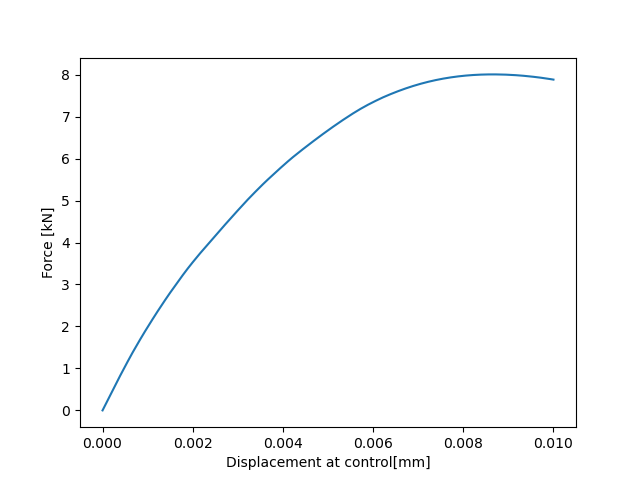

In [866]:
_, ax = plt.subplots(1,1)
ax.plot(-U_slide, -F_slide/1000)
ax.set_ylabel('Force [kN]')
ax.set_xlabel('Displacement at control[mm]')
# ax.legend()

Text(0.5, 0, 'Diferential displacement at ligament [mm]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
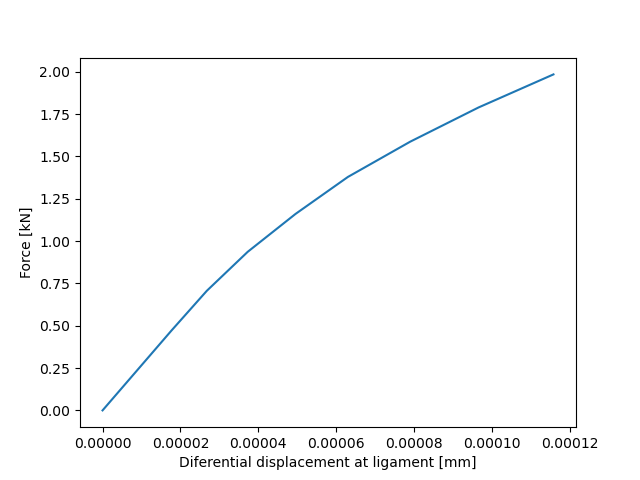

In [815]:
_, ax = plt.subplots(1,1)
ax.plot(abs(U_slide_differential_ligament), F_slide_ligament_upper/1000)
ax.set_ylabel('Force [kN]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
# ax.legend()
# abs(U_slide_middle_inner - U_slide_middle)[-1]

Text(0.5, 0, 'Displacement at control [mm]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
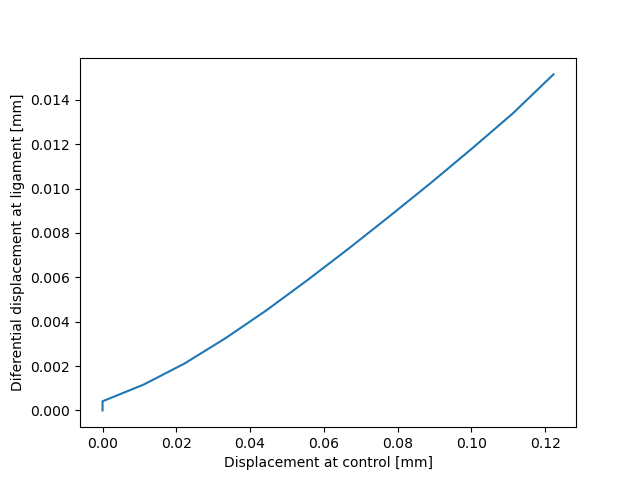

In [640]:
_, ax = plt.subplots(1,1)
ax.plot(-U_slide, abs(U_slide_differential_ligament))
ax.set_ylabel('Diferential displacement at ligament [mm]')
ax.set_xlabel('Displacement at control [mm]')
# ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
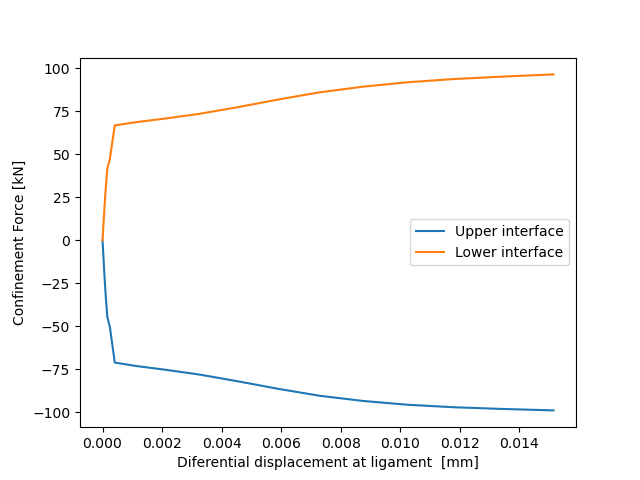

In [641]:
_, ax = plt.subplots(1,1)
ax.plot(U_slide_differential_ligament, F_confinement_ligament_upper/1000, label='Upper interface')
ax.plot(U_slide_differential_ligament, F_confinement_ligament_lower/1000, label='Lower interface')
ax.set_ylabel('Confinement Force [kN]')
ax.set_xlabel('Diferential displacement at ligament  [mm]')
ax.legend()

### Study about slide profile at ligament

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
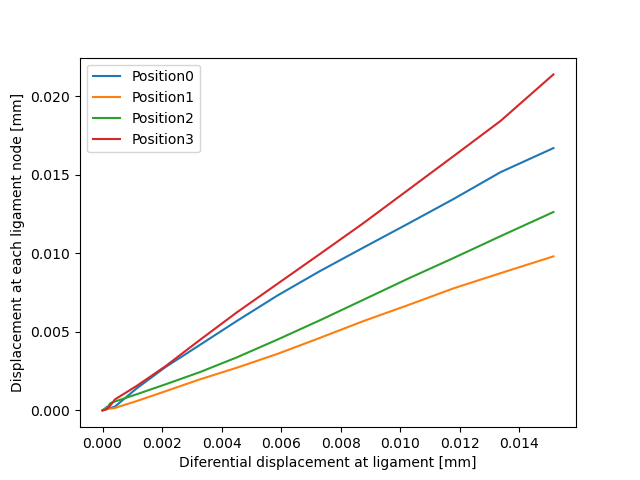

In [642]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    # ax.plot(U_slide_differential_ligament, U[:, ligament_upper_slide_dofs][:,i], label=str(i))
    # ax.plot(U_slide_differential_ligament, U[:, ligament_lower_slide_dofs][:,i], label=str(i))
    ax.plot(U_slide_differential_ligament, U[:, ligament_upper_slide_dofs][:,i] - U[:, ligament_lower_slide_dofs][:,i], label='Position' + str(i))
ax.set_ylabel('Displacement at each ligament node [mm]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
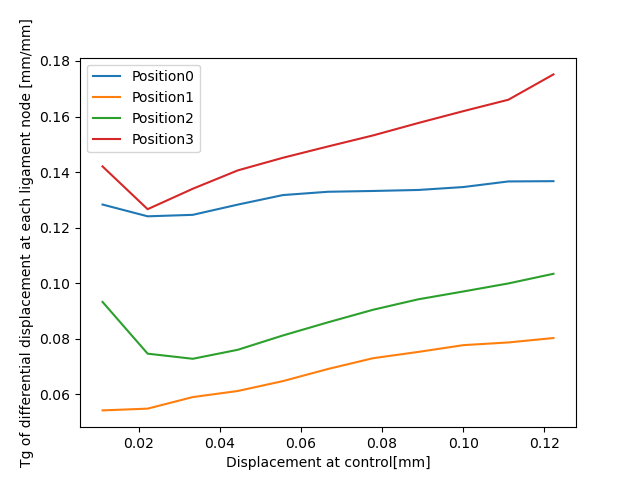

In [643]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(-U_slide, ((U[:, ligament_upper_slide_dofs][:,i] - U[:, ligament_lower_slide_dofs][:,i]))/-(U_slide), label='Position' + str(i))
    # print(((U[:, middle_confinement_dofs][:,i] - U[:, middle_confinement_inner_dofs][:,i])/-(U_slide))[-1])
ax.set_ylabel('Tg of differential displacement at each ligament node [mm/mm]')
ax.set_xlabel('Displacement at control[mm]')
ax.legend()

### Study about confinement profile at ligament

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
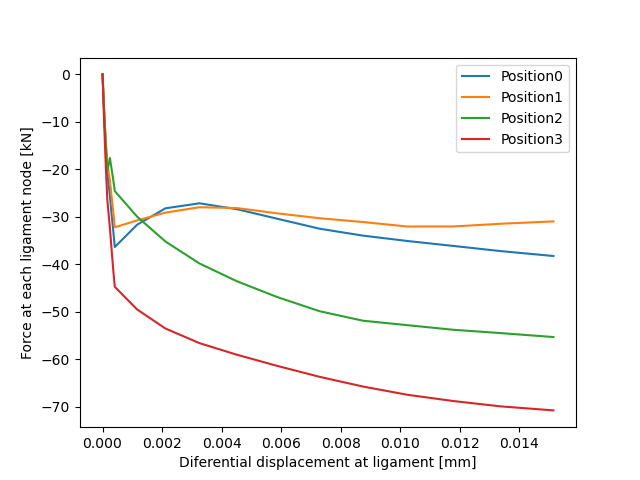

In [644]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    # ax.plot(U_slide_differential_ligament[:], F[:, ligament_upper_confinement_dofs][:,i]/1000, label=str(i))
    # ax.plot(U_slide_differential_ligament[:], F[:, ligament_lower_confinement_dofs][:,i]/1000, label=str(i))
    ax.plot(U_slide_differential_ligament, (F[:, ligament_upper_confinement_dofs][:,i] - F[:, ligament_lower_confinement_dofs][:,i])/1000, label='Position' + str(i))
ax.set_ylabel('Force at each ligament node [kN]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()

-313019.83790488605
-253346.5362082744
-452675.74211958604
-579110.4542058511


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
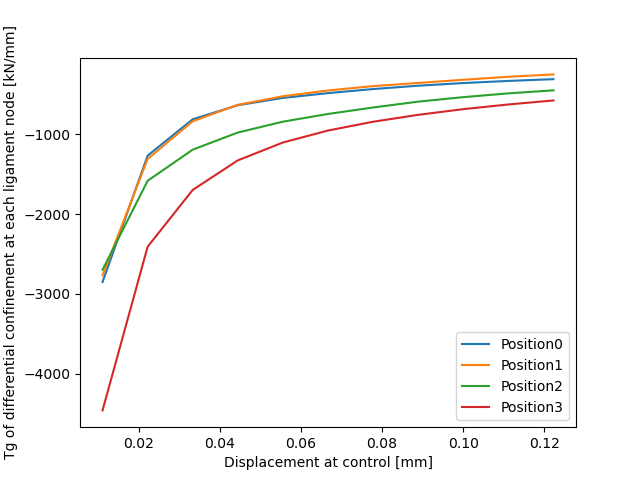

In [645]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    #ax.plot(-U_slide[:], (F[:, ligament_upper_confinement_dofs][:,i] - F[:, ligament_lower_confinement_dofs][:,i])/ (2* np.pi* R_out * L_x ), label=str(i))
    ax.plot(-U_slide[:], ((F[:, ligament_upper_confinement_dofs][:,i] - F[:, ligament_lower_confinement_dofs][:,i])/ 1000)/-(U_slide), label='Position' + str(i))
    print(((F[:, ligament_upper_confinement_dofs][:,i] - F[:, ligament_lower_confinement_dofs][:,i])/-(U_slide))[-1])
ax.set_ylabel('Tg of differential confinement at each ligament node [kN/mm]')
ax.set_xlabel('Displacement at control [mm]')
ax.legend()

### Study about dilatancy profile at ligament 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
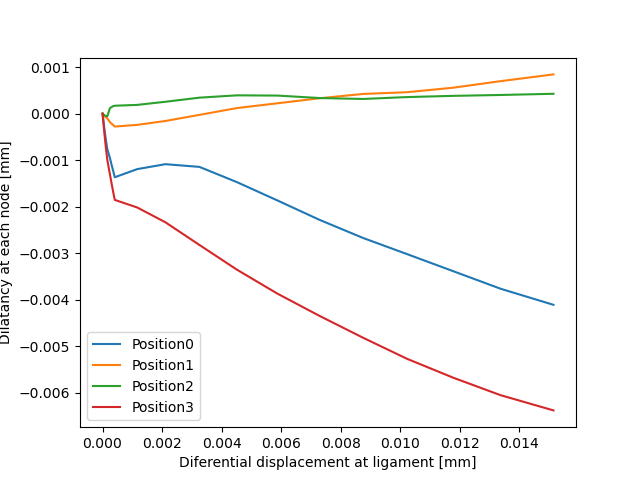

In [646]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    # ax.plot(U_slide_differential_ligament[:], U[:, ligament_upper_confinement_dofs][:,i], label= 'Position' + str(i))
    # ax.plot(U_slide_differential_ligament[:], U[:, ligament_lower_confinement_dofs][:,i], label= 'Position' + str(i))
    ax.plot(U_slide_differential_ligament, U[:, ligament_upper_confinement_dofs][:,i] - U[:, ligament_lower_confinement_dofs][:,i], label = 'Position' + str(i))
ax.set_ylabel('Dilatancy at each node [mm]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()


Text(0.5, 0, 'Control displacement [mm]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
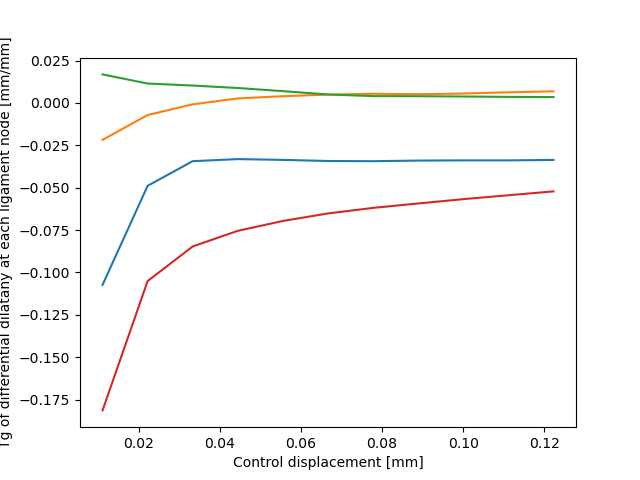

In [647]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(-(U_slide),  (U[:, ligament_upper_confinement_dofs][:,i] - U[:, ligament_lower_confinement_dofs][:,i])/-(U_slide))
    # print((( U[:, middle_control_dofs][:,i] - U[:, middle_inner_control_dofs][:,i])/-(U_slide))[-1])
ax.set_ylabel('Tg of differential dilatany at each ligament node [mm/mm]')
ax.set_xlabel('Control displacement [mm]')
# ax.legend()

In [648]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

ERROR|2022-01-11 18:14:55,304|Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001A58BFD1D60>, trait: data_range, old value: [0. 1.], new value: [3. 1.]
Traceback (most recent call last):
  File "C:\Users\marag\miniconda3\envs\bmcs_env\lib\site-packages\traits\trait_notifiers.py", line 342, in __call__
    self.handler(*args)
  File "C:\Users\marag\miniconda3\envs\bmcs_env\lib\site-packages\mayavi\core\lut_manager.py", line 434, in _data_range_changed
    assert value[0] <= value[1]
AssertionError
ERROR|2022-01-11 18:14:55,304|Exception occurred in traits notification handler for object: <mayavi.core.lut_manager.LUTManager object at 0x000001A58BFD1D60>, trait: data_range, old value: [0. 1.], new value: [3. 1.]
Traceback (most recent call last):
  File "C:\Users\marag\miniconda3\envs\bmcs_env\lib\site-packages\traits\trait_notifiers.py", line 342, in __call__
    self.handler(*args)
  File "C:\Users\marag\miniconda3\envs\bm

## Unit element Axisymm

In [370]:
n_x_e = 5
n_inner_y_e = 2
n_outer_y_e = 2
L_x = 50.0 # [mm]
d_x = L_x / n_x_e
R_in = 25 # [mm]
dR = 2 # [mm]
R_out = 50 # [mm]
len_notch = 20
n_notch = 1

xmodel = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0+n_notch*d_x, R_in),
                               coord_max=(L_x-n_notch*d_x, R_in+dR),
                               shape=(n_x_e-2*n_notch, 1),
                               fets=FETS2D4Q())

E = 34000

m_inelastic = MS13D(**CAxisymm)
m_elastic = MATS3DElastic(E=40000, nu=0.18)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [371]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.1)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=0.1)

In [372]:
slide_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[0], value=0.0)
slide_upper_dofs = slide_upper_slice.dofs

slide_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[0], value=0.0)
slide_lower_dofs = slide_lower_slice.dofs

confinement_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[1], value=0.0)
confinement_upper_dofs = confinement_upper_slice.dofs

confinement_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[1], value=0.0)
confinement_lower_dofs = confinement_lower_slice.dofs


In [428]:
factor = 1

# Boundary conditions with inner side fixed

slide = 0.05
compression_stress = -0

inner_fixed_0 = slide_lower_slice
inner_fixed_1 = confinement_lower_slice

compression_force = compression_stress  * 2 * np.pi* R_out * L_x / len(confinement_upper_dofs)
upper_compression_force = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in confinement_upper_dofs ]
upper_compression_force[0].value *=0.5
upper_compression_force[-1].value *=0.5

slide_upper = [BCDof(var='u', dof=dof, value=slide , time_function=tf_sliding) 
                     for dof in slide_upper_dofs ]
bc1 = [inner_fixed_0, inner_fixed_1] + slide_upper #+ upper_compression_force

# Boundary conditions with differential definition of ligament bc

inner_fixed_0 = slide_lower_slice
inner_fixed_1 = confinement_lower_slice
delta_dilatancy = U[:, ligament_upper_confinement_dofs] - U[:, ligament_lower_confinement_dofs]
delta_confinement = F[:, ligament_upper_confinement_dofs] - F[:, ligament_lower_confinement_dofs]
delta_slide = U[:, ligament_upper_slide_dofs] - U[:, ligament_lower_slide_dofs]

confinement_upper_0 = BCDof(var='u', dof=confinement_upper_dofs[0], value=delta_dilatancy[-1,0]*factor, time_function=tf_sliding)
confinement_upper_1 = BCDof(var='u', dof=confinement_upper_dofs[1], value=delta_dilatancy[-1,1]*factor, time_function=tf_sliding)
confinement_upper_2 = BCDof(var='u', dof=confinement_upper_dofs[2], value=delta_dilatancy[-1,2]*factor, time_function=tf_sliding)
confinement_upper_3 = BCDof(var='u', dof=confinement_upper_dofs[3], value=delta_dilatancy[-1,3]*factor, time_function=tf_sliding)

slide_upper_0 = BCDof(var='u', dof=slide_upper_dofs[0], value=delta_slide[-1,0]*factor, time_function=tf_sliding)
slide_upper_1 = BCDof(var='u', dof=slide_upper_dofs[1], value=delta_slide[-1,1]*factor, time_function=tf_sliding)
slide_upper_2 = BCDof(var='u', dof=slide_upper_dofs[2], value=delta_slide[-1,2]*factor, time_function=tf_sliding)
slide_upper_3 = BCDof(var='u', dof=slide_upper_dofs[3], value=delta_slide[-1,3]*factor, time_function=tf_sliding)


bc2 =   [confinement_upper_0, slide_upper_0,
        confinement_upper_1, slide_upper_1,
        confinement_upper_2, slide_upper_2,
        confinement_upper_3, slide_upper_3,
        inner_fixed_0, inner_fixed_1] 


# Boundary conditions with differential slide definition of ligament bc

inner_fixed_0 = slide_lower_slice
inner_fixed_1 = confinement_lower_slice
delta_slide = U[:, ligament_upper_slide_dofs] - U[:, ligament_lower_slide_dofs]

slide_upper_0 = BCDof(var='u', dof=slide_upper_dofs[0], value=delta_slide[-1,0]*factor, time_function=tf_sliding)
slide_upper_1 = BCDof(var='u', dof=slide_upper_dofs[1], value=delta_slide[-1,1]*factor, time_function=tf_sliding)
slide_upper_2 = BCDof(var='u', dof=slide_upper_dofs[2], value=delta_slide[-1,2]*factor, time_function=tf_sliding)
slide_upper_3 = BCDof(var='u', dof=slide_upper_dofs[3], value=delta_slide[-1,3]*factor, time_function=tf_sliding)


bc3 =   [slide_upper_0,
        slide_upper_1, 
        slide_upper_2, 
        slide_upper_3, 
        inner_fixed_0, inner_fixed_1] 

# Boundary conditions with full definition of ligament bc


confinement_upper_0 = BCDof(var='f', dof=confinement_upper_dofs[0], value=F[:, ligament_upper_confinement_dofs][-1,0]*factor, time_function=tf_sliding)
confinement_upper_1 = BCDof(var='f', dof=confinement_upper_dofs[1], value=F[:, ligament_upper_confinement_dofs][-1,1]*factor, time_function=tf_sliding)
confinement_upper_2 = BCDof(var='f', dof=confinement_upper_dofs[2], value=F[:, ligament_upper_confinement_dofs][-1,2]*factor, time_function=tf_sliding)
confinement_upper_3 = BCDof(var='f', dof=confinement_upper_dofs[3], value=F[:, ligament_upper_confinement_dofs][-1,3]*factor, time_function=tf_sliding)

confinement_lower_0 = BCDof(var='f', dof=confinement_lower_dofs[0], value=F[:, ligament_lower_confinement_dofs][-1,0]*factor, time_function=tf_sliding)
confinement_lower_1 = BCDof(var='f', dof=confinement_lower_dofs[1], value=F[:, ligament_lower_confinement_dofs][-1,1]*factor, time_function=tf_sliding)
confinement_lower_2 = BCDof(var='f', dof=confinement_lower_dofs[2], value=F[:, ligament_lower_confinement_dofs][-1,2]*factor, time_function=tf_sliding)
confinement_lower_3 = BCDof(var='f', dof=confinement_lower_dofs[3], value=F[:, ligament_lower_confinement_dofs][-1,3]*factor, time_function=tf_sliding)

slide_upper_0 = BCDof(var='u', dof=slide_upper_dofs[0], value=U[:, ligament_upper_slide_dofs][-1,0]*factor, time_function=tf_sliding)
slide_upper_1 = BCDof(var='u', dof=slide_upper_dofs[1], value=U[:, ligament_upper_slide_dofs][-1,1]*factor, time_function=tf_sliding)
slide_upper_2 = BCDof(var='u', dof=slide_upper_dofs[2], value=U[:, ligament_upper_slide_dofs][-1,2]*factor, time_function=tf_sliding)
slide_upper_3 = BCDof(var='u', dof=slide_upper_dofs[3], value=U[:, ligament_upper_slide_dofs][-1,3]*factor, time_function=tf_sliding)

slide_lower_0 = BCDof(var='u', dof=slide_lower_dofs[0], value=U[:, ligament_lower_slide_dofs][-1,0]*factor, time_function=tf_sliding)
slide_lower_1 = BCDof(var='u', dof=slide_lower_dofs[1], value=U[:, ligament_lower_slide_dofs][-1,1]*factor, time_function=tf_sliding)
slide_lower_2 = BCDof(var='u', dof=slide_lower_dofs[2], value=U[:, ligament_lower_slide_dofs][-1,2]*factor, time_function=tf_sliding)
slide_lower_3 = BCDof(var='u', dof=slide_lower_dofs[3], value=U[:, ligament_lower_slide_dofs][-1,3]*factor, time_function=tf_sliding)


bc4 =   [confinement_upper_0, confinement_lower_0, slide_upper_0, slide_lower_0,
        confinement_upper_1, confinement_lower_1, slide_upper_1, slide_lower_1,
        confinement_upper_2, confinement_lower_2, slide_upper_2, slide_lower_2,
        confinement_upper_3, confinement_lower_3, slide_upper_3, slide_lower_3
            ] 

In [421]:
m1 = copy.deepcopy(m)
m1.bc=bc1
m1.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s1 = m1.sim
s1.tloop.verbose = False
s1.tloop.k_max = 1000
s1.tline.step = 0.005/factor
# Accessing the following property - ensures serialization
s1.tstep.fe_domain.serialized_subdomains
s1.reset()
s1.run()

In [422]:
U_t1 = np.average(m1.hist.U_t[:, slide_upper_dofs] - m1.hist.U_t[:, slide_lower_dofs], axis=-1)
F_t1 = np.sum(m1.hist.F_t[:, slide_upper_dofs], axis=-1)

In [431]:
m2 = copy.deepcopy(m)
m2.bc=bc2
m2.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s2 = m2.sim
s2.tloop.verbose = False
s2.tloop.k_max = 1000
s2.tline.step = 0.005/factor
# Accessing the following property - ensures serialization
s2.tstep.fe_domain.serialized_subdomains
s2.reset()
s2.run()

In [432]:
U_t2 = np.average(m2.hist.U_t[:, slide_upper_dofs] - m2.hist.U_t[:, slide_lower_dofs], axis=-1)
F_t2 = np.sum(m2.hist.F_t[:, slide_upper_dofs], axis=-1)

In [429]:
# m3 = copy.deepcopy(m)
# m3.bc=bc3
# m3.hist.vis_record = {
# #    'strain': Vis3DTensorField(var='eps_ab'),
#     'stress': Vis3DTensorField(var='sig_ab'),
#     #        'kinematic hardening': Vis3DStateField(var='z_a')
# }

# s3 = m3.sim
# s3.tloop.verbose = False
# s3.tloop.k_max = 1000
# s3.tline.step = 0.005/factor
# # Accessing the following property - ensures serialization
# s3.tstep.fe_domain.serialized_subdomains
# s3.reset()
# s3.run()

In [408]:
# U_t3 = np.average(m3.hist.U_t[:, slide_upper_dofs] - m3.hist.U_t[:, slide_lower_dofs], axis=-1)
# F_t3 = np.sum(m3.hist.F_t[:, slide_upper_dofs], axis=-1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
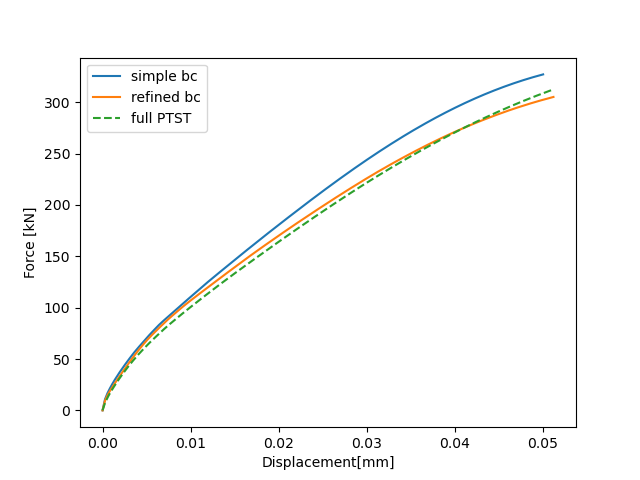

In [461]:
fig, (ax1) = plt.subplots(1)
ax1.plot(U_t1, F_t1/1000, label='simple bc')
ax1.plot(U_t2, F_t2/1000, label='refined bc')
# ax1.plot(U_t3, F_t3/1000, label='transferred bc')
ax1.plot(U_slide_differential_ligament, -F_slide/1000, '--', label='full PTST')
ax1.set_ylabel('Force [kN]')
ax1.set_xlabel('Displacement[mm]')
ax1.legend()
# ax2.plot(-U_t/(L_x-n_notch*2*d_x), -F_t/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)))
# # ax2.plot(-U_t/(L_x-n_notch*2*d_x), -F_t/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)))
# # ax2.set_ylabel('Stress [MPa]')
# # ax2.set_xlabel('Strain[-]')
# G = np.trapz(F_t, x=U_t)/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x))*1000
# G2 = np.trapz(F_t/(2 * np.pi * (R_in+dR)), x=U_t/(L_x-n_notch*2*d_x))
# print(G)
# print(G2)
# print(max(-F_t/1000))

In [315]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

In [137]:
# m.fe_domain[2].state_k

## Postprocesing

### Study about slide profile at ligament - PTST vs simple bc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
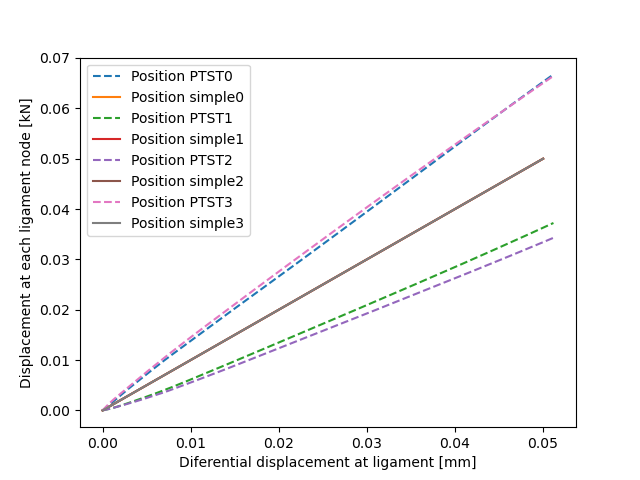

In [462]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(U_slide_differential_ligament, U[:, ligament_upper_slide_dofs][:,i] - U[:, ligament_lower_slide_dofs][:,i], '--', label='Position PTST' + str(i))
    ax.plot(U_t1, m1.hist.U_t[:, slide_upper_dofs][:,i] - m1.hist.U_t[:, slide_lower_dofs][:,i], label='Position simple' + str(i))
ax.set_ylabel('Displacement at each ligament node [kN]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()



### Study about slide profile at ligament - PTST vs refined bc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
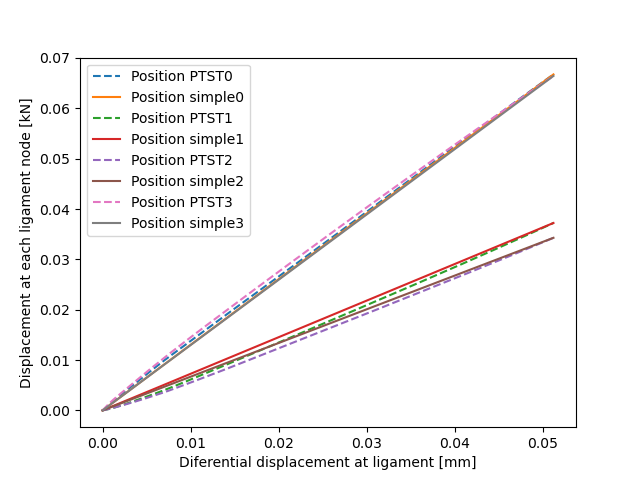

In [463]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(U_slide_differential_ligament, U[:, ligament_upper_slide_dofs][:,i] - U[:, ligament_lower_slide_dofs][:,i], '--', label='Position PTST' + str(i))
    ax.plot(U_t2, m2.hist.U_t[:, slide_upper_dofs][:,i] - m2.hist.U_t[:, slide_lower_dofs][:,i], label='Position simple' + str(i))
ax.set_ylabel('Displacement at each ligament node [kN]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()

### Study about confinement profile at ligament - PTST vs simple bc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
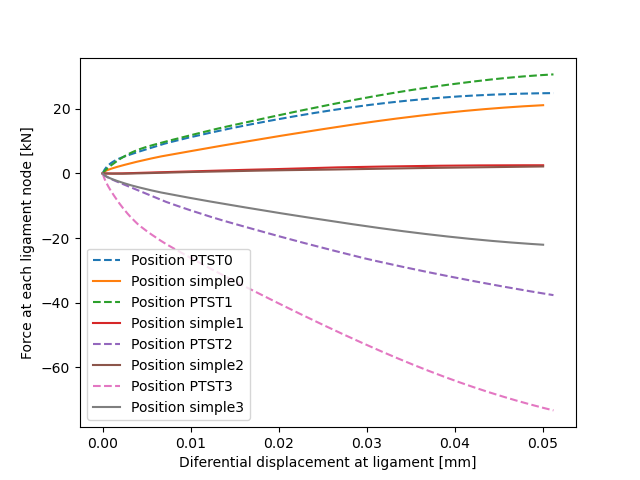

In [464]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(U_slide_differential_ligament, (F[:, ligament_upper_confinement_dofs][:,i] - F[:, ligament_lower_confinement_dofs][:,i])/1000, '--', label='Position PTST' + str(i))
    ax.plot(U_t1, (m1.hist.F_t[:, confinement_upper_dofs][:,i]- m1.hist.F_t[:, confinement_lower_dofs][:,i])/1000, label='Position simple' + str(i))
ax.set_ylabel('Force at each ligament node [kN]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()

### Study about slide profile at ligament - PTST vs refined bc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
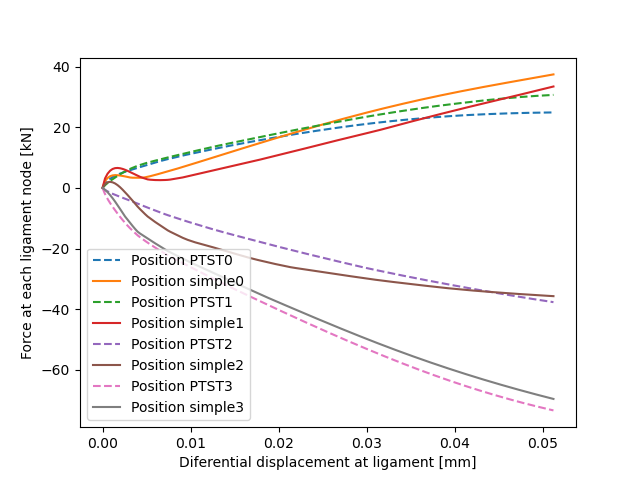

In [465]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(U_slide_differential_ligament, (F[:, ligament_upper_confinement_dofs][:,i] - F[:, ligament_lower_confinement_dofs][:,i])/1000, '--',label='Position PTST' + str(i))
    ax.plot(U_t2, (m2.hist.F_t[:, confinement_upper_dofs][:,i] - m2.hist.F_t[:, confinement_lower_dofs][:,i])/1000, label='Position simple' + str(i))
ax.set_ylabel('Force at each ligament node [kN]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()

### Study about dilatancy profile at ligament - PTST vs simple bc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
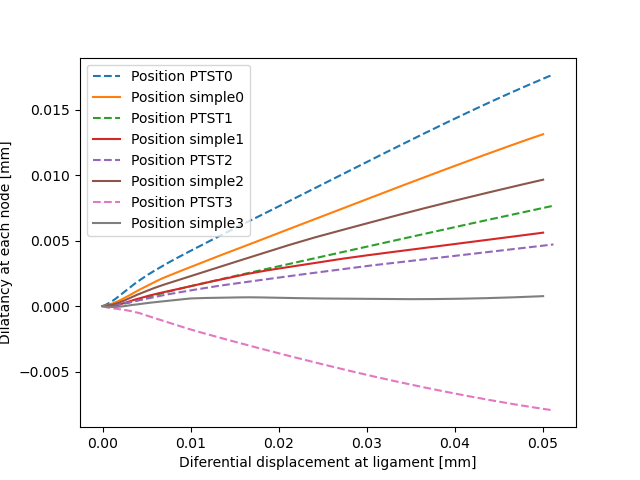

In [466]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(U_slide_differential_ligament, U[:, ligament_upper_confinement_dofs][:,i] - U[:, ligament_lower_confinement_dofs][:,i], '--', label = 'Position PTST' + str(i))
    ax.plot(U_t1, (m1.hist.U_t[:, confinement_upper_dofs][:,i] - m1.hist.U_t[:, confinement_lower_dofs][:,i]), label='Position simple' + str(i))
ax.set_ylabel('Dilatancy at each node [mm]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()


### Study about dilatancy profile at ligament - PTST vs refined bc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
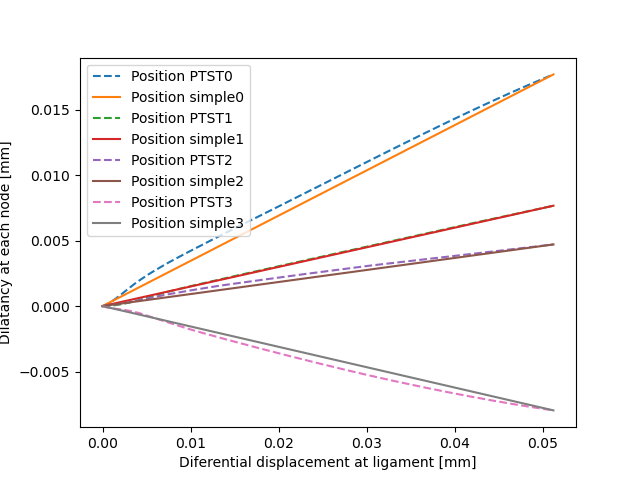

In [467]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(U_slide_differential_ligament, U[:, ligament_upper_confinement_dofs][:,i] - U[:, ligament_lower_confinement_dofs][:,i], '--', label = 'Position PTST' + str(i))
    ax.plot(U_t2, (m2.hist.U_t[:, confinement_upper_dofs][:,i] - m2.hist.U_t[:, confinement_lower_dofs][:,i]), label='Position simple' + str(i))
ax.set_ylabel('Dilatancy at each node [mm]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()


## Unit element 3D

In [2]:
CAxisymm = dict(E = 40e+3,    
                nu = 0.18,    
                Ad = 500.0,    
                eps_0 = 0.00001,    
                K_N = 17000.,    
                sigma_N_0 = 200., 
                gamma_N = 9000.,   
                sigma_T_0 = 3.0,   
                K_T = 200.0,  
                gamma_T = 5000,  
                S_T = 0.0007,  
                c_T = 2.9, 
                r_T = 3.,  
                m_T = 0.1, 
                p_T = 1.)


In [17]:
size_x = 1
size_y = 10
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13D(**CAxisymm)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [18]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.1)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=0.1)

In [19]:
w_max = 0.05

# Shear bc
bc_l_x = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                  var='u', dims=[0,1,2], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=-w_max/100)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]


In [20]:
bc1 = [bc_l_x]  + slide #+ compression_force_first

In [21]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.005
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
s.run()

1035.9576773090412
1.035957677309041


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
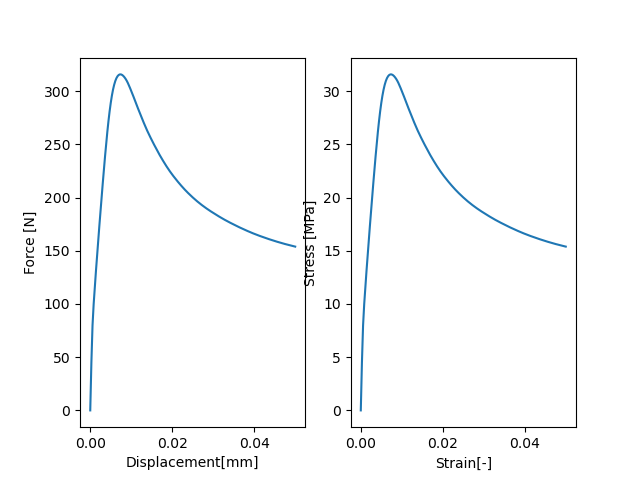

In [22]:
U_last = m.hist.U_t[-1]
F_last = m.hist.U_t[-1]
U_t = np.average(m.hist.U_t[:, slide_dofs], axis=-1)
F_t = np.sum(m.hist.F_t[:, slide_dofs], axis=-1)
fig, (ax1,ax2) = plt.subplots(1, 2)
ax1.plot(U_t, F_t)
ax1.set_ylabel('Force [N]')
ax1.set_xlabel('Displacement[mm]')
ax2.plot(U_t/size_x, F_t/(size_y*size_z))
ax2.set_ylabel('Stress [MPa]')
ax2.set_xlabel('Strain[-]')
G = np.trapz(F_t, x=U_t)/((size_z)*(size_y))*1000
G2 = np.trapz(F_t/(size_y*size_z), x=U_t/size_x)
print(G)
print(G2)

In [78]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

AttributeError: 'NoneType' object has no attribute 't_n'

## Increasing compressive level

In [33]:
m_list_monotnonic = []
compression_level = np.linspace(0,-30,3)

w_max = 0.05

for compression in compression_level:
    m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
    )
    # Shear bc
    bc_l_x = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                      var='u', dims=[0,1,2], value=0.0)

    slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                     var='u', dims=[1], value=w_max)
    slide_dofs = slide_slice.dofs
    slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                         for dof in slide_dofs ]


    compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                     var='u', dims=[0], value=-w_max/100)
    compression_dofs = compression_slice.dofs
    compression_force = compression * (size_y*size_z) / len(compression_dofs)
    compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                     for dof in compression_dofs ]

    bc1 = [bc_l_x]  + slide + compression_force_first

    m.bc=bc1
    m.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = 0.01
    # Accessing the following property - ensures serialization
    s.tstep.fe_domain.serialized_subdomains
    s.reset()
    s.run()
    m_list_monotnonic.append(m)

972.4102080212923
0.9724102080212923
1370.7806980025352
1.3707806980025352
1613.0620869485376
1.6130620869485377


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
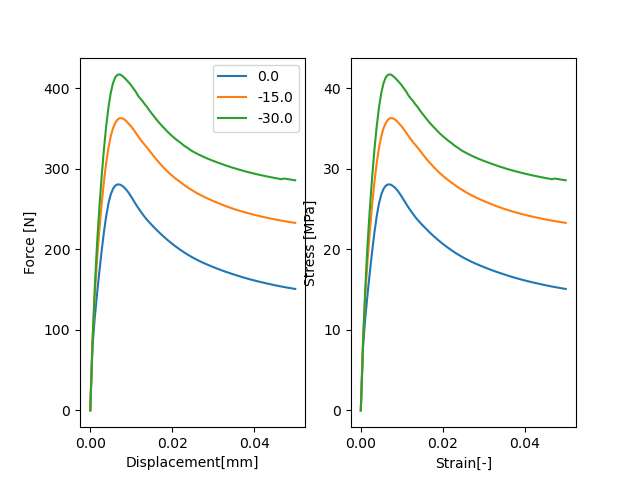

In [34]:
fig, (ax1,ax2) = plt.subplots(1, 2)
max_F = []
for m,compression in zip(m_list_monotnonic,compression_level):
    U_t = np.average(m.hist.U_t[:, slide_dofs], axis=-1)
    F_t = np.sum(m.hist.F_t[:, slide_dofs], axis=-1)
    max_F.append(max(abs(F_t)))
    ax1.plot(U_t, F_t, label=str(compression))
    ax1.set_ylabel('Force [N]')
    ax1.set_xlabel('Displacement[mm]')
    ax2.plot(U_t/size_x, F_t/(size_y*size_z))
    ax2.set_ylabel('Stress [MPa]')
    ax2.set_xlabel('Strain[-]')
    G = np.trapz(F_t, x=U_t)/((size_z)*(size_y))*1000
    G2 = np.trapz(F_t/(size_y*size_z), x=U_t/size_x)
    print(G)
    print(G2)
ax1.legend()

In [47]:
max_F
#max_F = [280.6420729919637, 362.95746639324466, 417.2102099784797]
max_F = [417.2102099784797, 417.2102099784797, 417.2102099784797]

In [48]:
number_of_cycles = 100
shift_cycles = 1
tf_cyclic = TFCyclicNonsymmetricConstant(number_of_cycles=number_of_cycles, unloading_ratio=0.05, shift_cycles=shift_cycles)
tf_confinement = TFBilinear(loading_ratio=1, time_ratio=1/(number_of_cycles+shift_cycles))

In [49]:
m_list = []
compression_level = np.linspace(0,-30,3)
S_max = 0.5
w_max = 0.05

for compression, slide_force in zip(compression_level, max_F):
    m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
    )
    # Shear bc
    bc_l_x = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                      var='u', dims=[0,1,2], value=0.0)

    slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                     var='u', dims=[1], value=0)
    slide_dofs = slide_slice.dofs
    slide_force = S_max * slide_force / len(slide_dofs)
    slide = [BCDof(var='f', dof=dof, value=slide_force , time_function=tf_cyclic) 
                         for dof in slide_dofs ]


    compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                     var='u', dims=[0], value=-w_max/100)
    compression_dofs = compression_slice.dofs
    compression_force = compression * (size_y*size_z) / len(compression_dofs)
    compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_confinement) 
                                     for dof in compression_dofs ]

    bc1 = [bc_l_x]  + slide + compression_force_first

    m.bc=bc1
    m.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = 0.0001
    # Accessing the following property - ensures serialization
    s.tstep.fe_domain.serialized_subdomains
    s.reset()
    s.run()
    m_list.append(m)

In [44]:
compression * (size_y*2*2*np.pi*25)/1000

-94.24777960769379

245.7743039582892
0.2457743039582892
41.170009125865526
0.04117000912586555
24.1910211741915
0.02419102117419151


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
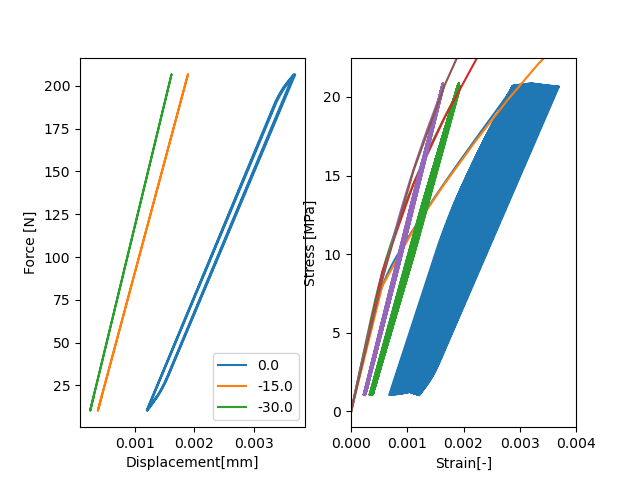

In [53]:
fig, (ax1,ax2) = plt.subplots(1, 2)
for m,m_monotonic,compression in zip(m_list,m_list_monotnonic,compression_level):
    U_t = np.average(m.hist.U_t[:, slide_dofs], axis=-1)
    F_t = np.sum(m.hist.F_t[:, slide_dofs], axis=-1)
    U_t_mon = np.average(m_monotonic.hist.U_t[:, slide_dofs], axis=-1)
    F_t_mon = np.sum(m_monotonic.hist.F_t[:, slide_dofs], axis=-1)
    ax1.plot(U_t[-300:], F_t[-300:], label=str(compression))
    ax1.set_ylabel('Force [N]')
    ax1.set_xlabel('Displacement[mm]')
    ax2.plot(U_t/size_x, F_t/(size_y*size_z))
    ax2.plot(U_t_mon/size_x, F_t_mon/(size_y*size_z))
    ax2.set_ylabel('Stress [MPa]')
    ax2.set_xlabel('Strain[-]')
    ax2.set_xlim(-0.00001,0.004)
    ax2.set_ylim(-1,22.5)
    G = np.trapz(F_t, x=U_t)/((size_z)*(size_y))*1000
    G2 = np.trapz(F_t/(size_y*size_z), x=U_t/size_x)
    print(G)
    print(G2)
ax1.legend()

## parametric m parameter

In [55]:
m_list = []
m_parameter_list = np.linspace(0,0.1,3)

w_max = 0.05

for m_parameter in m_parameter_list:
    CAxisymm['m_T'] = m_parameter
    m_inelastic = MS13D(**CAxisymm)
    m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
    )
    # Shear bc
    bc_l_x = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                      var='u', dims=[0,1,2], value=0.0)

    slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                     var='u', dims=[1], value=w_max)
    slide_dofs = slide_slice.dofs
    slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                         for dof in slide_dofs ]


    compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                     var='u', dims=[0], value=-w_max/100)
    compression_dofs = compression_slice.dofs
    compression_force = -30 * (size_y*size_z) / len(compression_dofs)
    compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                     for dof in compression_dofs ]

    bc1 = [bc_l_x]  + slide + compression_force_first

    m.bc=bc1
    m.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = 0.01
    # Accessing the following property - ensures serialization
    s.tstep.fe_domain.serialized_subdomains
    s.reset()
    s.run()
    m_list.append(m)

1688.1536376678903
0.8440768188339451
1733.4811995757539
0.8667405997878771
1734.7328616906054
0.8673664308453031


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
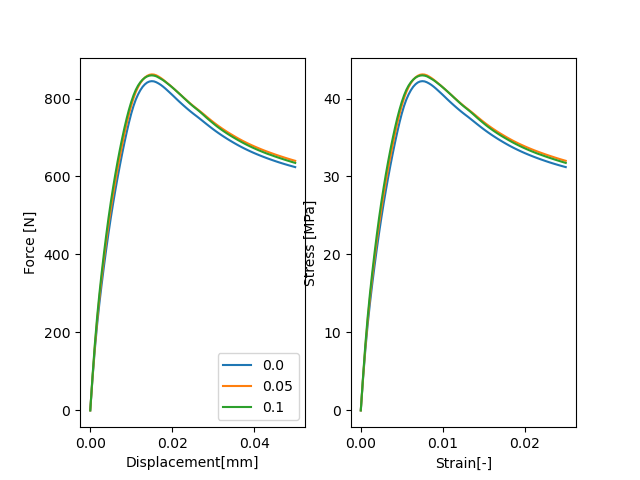

In [56]:
fig, (ax1,ax2) = plt.subplots(1, 2)

for m,m_parameter in zip(m_list,m_parameter_list):

    U_last = m.hist.U_t[-1]
    F_last = m.hist.U_t[-1]
    U_t = np.average(m.hist.U_t[:, slide_dofs], axis=-1)
    F_t = np.sum(m.hist.F_t[:, slide_dofs], axis=-1)
    ax1.plot(U_t, F_t, label=str(m_parameter))
    ax1.set_ylabel('Force [N]')
    ax1.set_xlabel('Displacement[mm]')
    ax2.plot(U_t/size_x, F_t/(size_y*size_z))
    ax2.set_ylabel('Stress [MPa]')
    ax2.set_xlabel('Strain[-]')
    G = np.trapz(F_t, x=U_t)/((size_z)*(size_y))*1000
    G2 = np.trapz(F_t/(size_y*size_z), x=U_t/size_x)
    print(G)
    print(G2)
ax1.legend()